## Image classification using ResNet50

### Prepare model and test data

In [1]:
import json
import numpy as np
import tensorflow as tf
# tf.compat.v1.disable_v2_behavior() # disable TF2 behaviour as alibi code still relies on TF1 constructs
from tensorflow.keras.applications import ResNet50
from PIL import Image as PilImage
import matplotlib.pyplot as plt

2024-06-16 20:43:54.889783: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-16 20:43:54.892879: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-16 20:43:54.931208: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-16 20:43:54.931234: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-16 20:43:54.931265: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to regi

We recommend using `Image` to represent a batch of images. `Image` can be constructed from a numpy array or a Pillow image. The following code loads one test image and resizes them to (224, 224).

In [14]:
# Load the test image
img_raw = PilImage.open('../data/image/jellyfish.png').convert('RGB').resize((224,224))
img = tf.keras.preprocessing.image.img_to_array(img_raw)
tf.keras.applications.resnet.preprocess_input(img)
# img = img[np.newaxis,:,:,:]
# Load the class names
with open('../data/image/imagenet_class_index.json', 'r') as read_file:
    class_idx = json.load(read_file)
    idx2label = [class_idx[str(k)][1] for k in range(len(class_idx))]

In [3]:
model = ResNet50(include_top=True, weights='imagenet', classes=1000)

2024-06-16 20:43:56.968739: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2211] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


The preprocessing function takes an `Image` instance as its input and outputs the processed features that the ML model consumes. In this example, each image in the `Image` object is transformed via `tf.keras.preprocessing.image.img_to_array` followed by `resnet.preprocess_input`.

In [4]:
# The preprocessing function
def resnet_fn(array):
    model = ResNet50(include_top=True, weights='imagenet', classes=1000)
    return model.predict(array)

Let's check the predicted labels of this test image.

In [5]:
predictions = model.predict(img[np.newaxis,:,:,:])
top_indices = np.argsort(predictions)[0, ::-1][:5]
r = tuple((i, idx2label[i]) for i in top_indices)
print(r)

1/1 [==============================] - 1s 788ms/step
((107, 'jellyfish'), (108, 'sea_anemone'), (393, 'anemone_fish'), (117, 'chambered_nautilus'), (1, 'goldfish'))


Load background images for algorithms like SHAP, LIME. Randomly sampled from imagenet training set.

In [6]:
import glob
import os
# Load the test image
png_files = glob.glob(os.path.join('/home/kxlu/Documents/xai_compare/data/image/imagenet_1000','*.png'))
bg_img_list = []
for png_file in png_files:
    bg_img_list.append(PilImage.open(png_file).convert('RGB').resize((224,224)))

/home/kxlu/anaconda3/envs/alibi/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-06-16 20:09:43,655	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2024-06-16 20:09:47.752208: W tensorflow/c/c_api.cc:305] Operation '{name:'conv4_block2_2_conv_1/bias/Assign' id:8782 op device:{requested: '', assigned: ''} def:{{{node conv4_block2_2_conv_1/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](conv4_block2_2_conv_1/bias, conv4_block2_2_conv_1/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them o

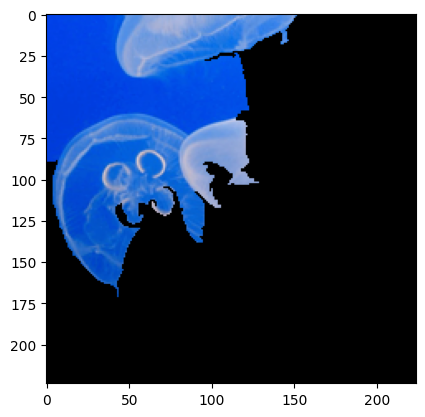

In [7]:
from alibi.explainers import AnchorImage
explainer = AnchorImage(predictor=resnet_fn,
                        image_shape=(224,224,3), segmentation_fn='slic',
                        segmentation_kwargs={'n_segments': 15, 'compactness': 20, 'sigma': .5},
                        images_background=None)
explanation = explainer.explain(img)
plt.imshow(explanation.anchor)

In [8]:
from alibi.explainers import CEM
explainer = CEM(resnet_fn,
          'pn',
          shape=(1,224,224,3),
          no_info_val = np.zeros((1,224,224,3)))

explanation = explainer.explain(img[np.newaxis,:,:,:])

2024-06-16 20:13:24.334007: W tensorflow/c/c_api.cc:305] Operation '{name:'conv4_block2_1_bn_21/moving_variance/Assign' id:131757 op device:{requested: '', assigned: ''} def:{{{node conv4_block2_1_bn_21/moving_variance/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](conv4_block2_1_bn_21/moving_variance, conv4_block2_1_bn_21/moving_variance/Initializer/ones)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-06-16 20:13:29.198641: W tensorflow/c/c_api.cc:305] Operation '{name:'predictions_21/Softmax' id:134065 op device:{requested: '', assigned: ''} def:{{{node predictions_21/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](predictions_21/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effec

UnboundLocalError: local variable 'X_der' referenced before assignment

In [14]:
from alibi.explainers import Counterfactual
explainer = Counterfactual(
    resnet_fn,
    shape = (1,224,224,3),
    target_proba=0.2,
    target_class='other', 
    max_iter=10,
    lam_init=1e-2
    )

explanation = explainer.explain(img[np.newaxis,:,:,:])
# plt.imshow(explanation.)

2024-06-16 20:21:01.860555: W tensorflow/c/c_api.cc:305] Operation '{name:'conv4_block3_2_bn_29/beta/Assign' id:181777 op device:{requested: '', assigned: ''} def:{{{node conv4_block3_2_bn_29/beta/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](conv4_block3_2_bn_29/beta, conv4_block3_2_bn_29/beta/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-06-16 20:21:08.424224: W tensorflow/c/c_api.cc:305] Operation '{name:'predictions_29/Softmax' id:183728 op device:{requested: '', assigned: ''} def:{{{node predictions_29/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](predictions_29/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future.

: 

In [8]:
from alibi.explainers import CounterfactualProto
explainer = CounterfactualProto(
    resnet_fn,
    shape = (1,224,224,3),
)
explainer.explain(img[np.newaxis,:,:,:])

2024-06-16 20:40:18.307089: W tensorflow/c/c_api.cc:305] Operation '{name:'conv3_block1_3_conv_2/bias/Assign' id:13745 op device:{requested: '', assigned: ''} def:{{{node conv3_block1_3_conv_2/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](conv3_block1_3_conv_2/bias, conv3_block1_3_conv_2/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-06-16 20:40:19.339630: W tensorflow/c/c_api.cc:305] Operation '{name:'predictions_2/Softmax' id:17347 op device:{requested: '', assigned: ''} def:{{{node predictions_2/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](predictions_2/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. 

AttributeError: 'CounterfactualProto' object has no attribute 'cat_vars_ord'

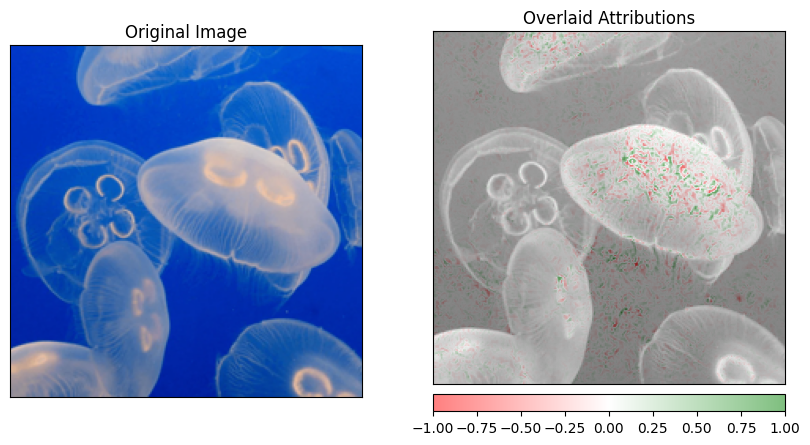

(<Figure size 1000x500 with 3 Axes>,
 <Axes: title={'center': 'Overlaid Attributions'}>)

In [17]:
from alibi.explainers import IntegratedGradients

explainer = IntegratedGradients(
    model,
)
explanation = explainer.explain(img[np.newaxis,:,:,:],baselines=np.zeros((1,224,224,3)),target=107)
attrs = explanation.attributions[0]
from alibi.utils import visualize_image_attr
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
visualize_image_attr(attr=None, original_image=img_raw, method='original_image',
                    title='Original Image', plt_fig_axis=(fig, ax[0]), use_pyplot=False)

visualize_image_attr(attr=attrs.squeeze(), original_image=img_raw, method='blended_heat_map',
                    sign='all', show_colorbar=True, title='Overlaid Attributions',
                     plt_fig_axis=(fig, ax[1]), use_pyplot=True)

### Similarity explanations

Remain to be done because requires training on full dataset

### VIT